In [1]:
import numpy as np
import pandas as pd
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

In [2]:
class dynamical_system:
    '''
    A set of inheritable methods to solve dynamical systems
    '''
    def integrate(self,tinit, tmax, dt, x0,method='RK45'):
        '''
        Solves a differental equation from tinit to tmax and storing the 
        solution value dt intervals.
        
        Args: 
            tinit: inital time of the system
            tmax: final time of the system
            x0: initial value of the system
            method: numerical scheme to compute the solution
        
        Returns:
            sol: the solution from solve_ivp that contains integration parameters
        '''
        t_eval =  np.arange(tinit, tmax, dt)
        sol=solve_ivp(self.rhs, [tinit, tmax], x0, t_eval = t_eval,method='RK45')
        self.xs = (sol.y).T
        self.ts = sol.t
        return sol
    
    def trajectory_plot(self,ind=[0,1,2]):
        '''
        Three dimension plot of a cross section of phase space
        
        Args:
            ind: indices of the states used to generate the cross section
        '''
        plt.rcParams.update(plt.rcParamsDefault)
        fig=plt.figure()
        ax = fig.gca(projection='3d')
        #generate plot object
        ax.plot(self.xs[:,ind[0]],self.xs[:,ind[1]],self.xs[:,ind[2]])
        
        #label axes
        ax.set_xlabel('$x_'+str(ind[0])+'$')
        ax.set_ylabel('$x_'+str(ind[1])+'$')
        ax.set_zlabel('$x_'+str(ind[2])+'$')
        plt.show()
        
    def evolution_plot(self,filename=None,ind=None,legnames=None):
        '''
        Plot of evolution of states with respect to time
        
        Args:
            ind: indices of the states plot evolution
        '''
        plt.rcParams.update(plt.rcParamsDefault)
        if (ind is not None):
            #generate plot object
            plt.plot(self.ts,self.xs[:,ind])
            #legend
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in ind]
        else:
            #generate plot object
            plt.plot(self.ts,self.xs)
            #legend
            ind = (self.xs).shape[1]
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in range(0,ind)]
            
            
        #label axes
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        
        plt.legend(legnames,loc="upper right")

        if filename:
            plt.savefig(filename)
        plt.show()

In [3]:
class Kuramoto(dynamical_system):
    def __init__(self, N, K, omega, sigma=0):
        '''
        creates a Kuramoto class with N oscillators, coupling term K
        and natural frequency, omega
        
        Args:
            N: number of oscillators
            K: number
        '''
        #number of oscillators
        self.N = N
        #coupling term
        self.K = K
        #natural frequency
        self.omega = omega
        #noise term
        self.sigma=sigma
        
    def rhs(self,t,x):
        '''
        Calculates dx/dt of the Kuramoto equation at state, x, and time, t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: the vector field at x, t.
        '''
        #natural frequency
        omega = self.omega
        #number of oscillators
        N = self.N
        #coupling term
        K = self.K
        
        #calculate dxdt
        temp = np.reshape(x, (N,-1))
        xmat = np.repeat(temp,N,axis=1)
        dxdt = omega + (K/N)*np.sum(np.sin(x-xmat),axis=1)
        return dxdt
    
    
    def rk4step(self, tinit, yinit, dt):
        # Taken from Niall's EA4 class

        '''
        [t,y] = rk4step(rhs, t0, y0, opts)
        Calculate a single RK4 step from t0 to t0 + opts.dt, returning the new 
        t,y pair
        '''

        yt = yinit
        tt = tinit
        k1 = self.rhs(tt, yt);

        yt = yinit + dt*0.5*k1;
        tt = tinit + dt*0.5;
        k2 = self.rhs(tt, yt);

        yt = yinit + dt*0.5*k2 
        # tt = tinit + opts.dt*0.5  % Same time on this step
        k3 = self.rhs(tt, yt)

        yt = yinit + dt*k3
        tt = tinit + dt
        k4 = self.rhs(tt, yt)

        y = yinit + (dt/6.0)*(k1 + 2.0*k2 + 2.0*k3 + k4)
        t = tt 

        return [t,y]
    def euler_maruyama_step(self,tinit,yinit,dt):
        '''
        Implements Euler Maruyama for an SDE. 
        See https://en.wikipedia.org/wiki/Euler-Maruyama_method
        
        Args: 
            tinit: initial time
            y_init: inital states
            tmax: final time
            N: number of time points
            
        Returns:
            y: states at time points, tinit + dt
            t: tinit + dt
        '''
        
        tt=tinit
        yy=yinit
        
        a_fun = self.rhs(tt, yy) 
        b_fun = self.sigma
        
        dW = np.random.normal(loc=0.0, scale=np.sqrt(dt),size=self.N)

        y = yy + a_fun*dt + b_fun*dW 
        t = tt + dt
        
        return [t,y] 
    
    def integrate(self, tinit,tfin, dt, yinit,plotIter = False):
        '''
        # [t_out, y_out] = ode(method, rhs, t_range, y_init, opts) : solve an ODE
        ##########################################################################
        # Taken from Niall's EA4 class
        # Solve the ODE encoded in rhs() using method opts.method(). 
        # This routine essentially only handles output, recording the system state
        # at times along the evolution.
        # 
        # INPUT:
        #   rhs()    : Function handle to the rhs of the form
        #              rhs(t_now, y_now, opts)
        #   t_range  : A vector of the form t_range = [t_init t_final]
        #   y_init   : The initial condition
        #   opts     : A struct of the method options. Must at least include
        #                 dt     : the timestep size
        #                 method : a function handle to the numerical method of the 
        #                          form method(rhs, t_now, y_now, opts)
        #              The structure may include additional parameters to be passed
        #              to the method or the rhs.
        ##########################################################################
        '''
     
        # Estimate length of output and allocate some memory
        prealloc = int( 1.5*(tfin - tinit)/dt )
        t_out = np.zeros(prealloc);
        y_out = np.zeros( (prealloc, np.shape(yinit)[0]))
        # Record IC
        t_out[0] = tinit
        y_out[0,:] = yinit
        inext = 1
        # Markers for current step
        t = tinit
        y = yinit
        tprev = 0
        if plotIter:
            s=np.linspace(0,2*np.pi,100)
            
        while (t < tfin):
            # Take a step
            if self.sigma == 0:
                [t,y] = self.rk4step(t, y,dt)
            else:
                [t,y] = self.euler_maruyama_step(t, y,dt)

            # Record step
            t_out[inext] = t
            y_out[inext,:] = y
            
            if plotIter and int(inext)% 20 == 0:
                tprev=t
                clear_output(wait=True)
                plt.plot(np.cos(s),np.sin(s))
                plt.scatter(np.cos(y),np.sin(y),c='r',marker='o')
                plt.title('t = ' + str(t))
                plt.show()
                plt.pause(0.5)
                plt.clf()
            inext = inext + 1

        # Trim output to size
        self.ts = t_out[:inext]
        self.xs = y_out[:inext,:]
        
        return [self.ts, self.xs]

# Deterministic Kuramoto Model

In [4]:
# these are our constants
N = 5  # number of variables
K = 10 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([117.35002435, 261.94283291, 260.06912657, 293.69995793,235.11319532]) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.01

In [5]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0,False)

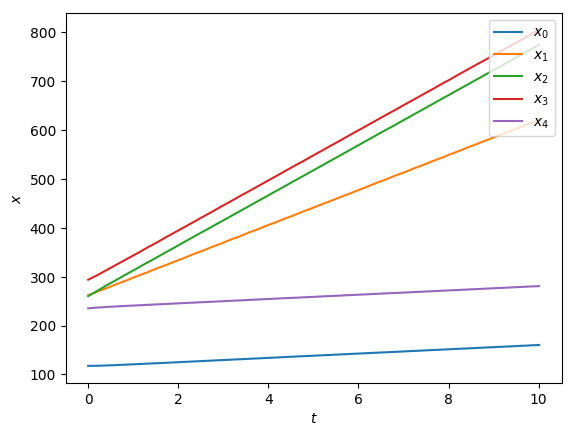

In [6]:
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/kuramoto_evolution.jpg'
kuramoto.evolution_plot(filename)

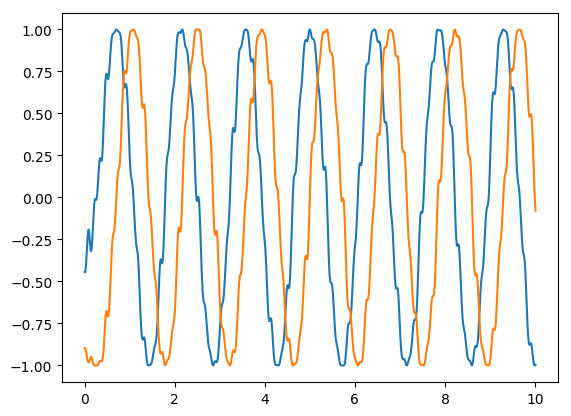

In [7]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['x0','x1','x2','x3','x4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(col).strip() for col in kuramoto_transform_df.columns.values]
plt.cla()
plt.plot(sol[0],kuramoto_transform_df['x0cos'])
plt.plot(sol[0],kuramoto_transform_df['x0sin'])
plt.show()

# Kuramoto Model with Guassian Noise

In [8]:
# these are our constants
N = 5  # number of variables
K = 10 #coupling
omega =  np.array([ 2.31246433, 35.50794494, 53.41350736, 50.23353682,  5.63392492])  # natural frequency
theta0 = np.array([117.35002435, 261.94283291, 260.06912657, 293.69995793,235.11319532]) # initial state 
tinit = 0.0
sigma = 2
tmax = 10.0
dt =  0.01

In [9]:
kuramoto = Kuramoto(N,K,omega,sigma)
sol = kuramoto.integrate(tinit, tmax, dt, theta0,False)

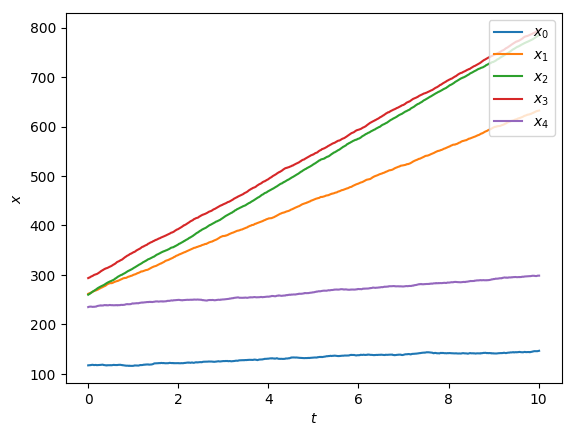

In [10]:
filename = '/Users/aarcher/PycharmProjects/Data Driven Dynamical Systems/Kuramoto/pictures/noisy_kuramoto_evolution.jpg'
kuramoto.evolution_plot(filename)

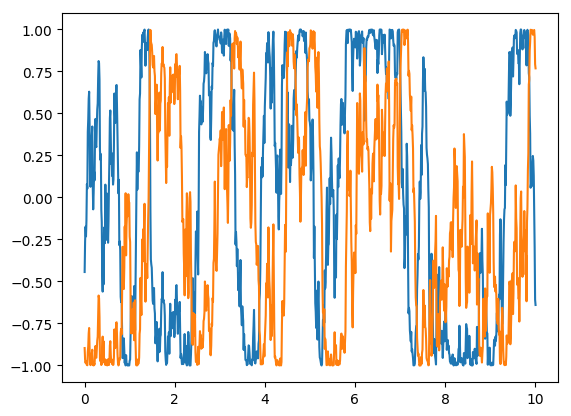

In [11]:
kuramoto_df = pd.DataFrame(data= sol[1],    
                columns=['x0','x1','x2','x3','x4'])
kuramoto_transform_df = kuramoto_df.transform([np.cos,np.sin])
kuramoto_transform_df.columns = [''.join(col).strip() for col in kuramoto_transform_df.columns.values]
plt.cla()
plt.plot(sol[0],kuramoto_transform_df['x0cos'])
plt.plot(sol[0],kuramoto_transform_df['x0sin'])
plt.show()